# Определение перспективного тарифа для телеком компании


Я аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Мне предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В моём распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

---

## Описание тарифов

### Тариф «Смарт»

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
      минута разговора: 3 рубля
      сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
      минута разговора: 1 рубль
      сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

_Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута._

---

## Описание данных
### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

---

## Шаг 1. Открыть файлы и изучить общую информацию

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_users = pd.read_csv('/datasets/users.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [3]:
# calls
print(df_calls.info())
display(df_calls.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


__id тип object__

__call_date переведём в datetime__

__может, стоит что-то сделать с duration- округлить до минут в большую сторону, например__

In [4]:
# users
print(df_users.info())
display(df_users.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


__Непонятно пока, надо ли что-то делать с churn_date - поменявших тариф всего 38. Посмотрим, может, стоит перевести в datetime, если это понадобится для анализа__

__reg_date переведём в datetime__

In [5]:
# messages

print(df_messages.info())
display(df_messages.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


__id тип object__

__message_date переведём в datetime__

In [6]:
#internet

print(df_internet.info())
display(df_internet.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


__Что такое unnamed: 0 пока непонятно- посмотрим дальше.__

__id имеет тип object - поменяем, если будем пользоваться.__

__Session_date переведём в datetime.__

In [7]:
# tariffs

print(df_tariffs.info())
display(df_tariffs.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


__с датасетом всё в порядке__

## Вывод

Имеется пять датасетов, связь между которыми осуществляется через общие колонки, такие как user_id или tariff_name. Каждый из них просмотрен, снизу под каждым написаны мои комментарии.

---

## Шаг 2. Предобработка данных

### calls

In [8]:
df_calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [9]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')
df_calls.loc[df_calls['duration'] == 0, 'duration'] = 1
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls['duration'] = df_calls['duration'].astype('int')



In [10]:
# Добавим столбец месяцев звонков для группировки.
df_calls['month'] = df_calls['call_date'].dt.month

In [11]:
df_calls_gr = df_calls.groupby(['user_id', 'month']).agg({'duration': 'sum', 'user_id' : 'count'})
df_calls_gr = df_calls_gr.reset_index(level = 'month')
df_calls_gr.columns = ['month', 'calls_duration', 'calls_amount']
df_calls_gr

,month,calls_duration,calls_amount
user_id,,,
1000,5,164,22
1000,6,187,43
1000,7,346,47
1000,8,418,52
1000,9,478,58
...,...,...,...
1498,10,258,41
1499,9,71,9
1499,10,473,68


### Микровывод

0.00 в времени звонка- это сразу сброшенный звонок, за который снимаются деньги, как за минуту. Сразу прибавляем к нулям единицу и переводим в int.
Таким образом я решил проблемы со всей тарификацией по звонкам- прибавил ко всем строкам duration единицу и перевёл в int.

Также перевёл в datetime столбец call_date.

В сгрупированной таблице df_calls_gr создал столбцы месяца, количества и длительности звонков по месяцам.

### users

In [12]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')
df_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


### Микровывод

Перевёл reg_date в datetime. churn_date пока трогать не стал.

### messages

In [13]:
#Предобработка и переименование колонок для merge

df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')
df_messages['month'] = df_messages['message_date'].dt.month
df_messages_gr = df_messages.groupby(['user_id', 'month']).agg({'user_id' : 'count'})
df_messages_gr = df_messages_gr.reset_index(level = 'month')
df_messages_gr.columns = ['month', 'messages_amount']
df_messages_gr

,month,messages_amount
user_id,,
1000,5,22
1000,6,60
1000,7,75
1000,8,81
1000,9,57
...,...,...
1498,10,42
1499,9,11
1499,10,48


### Микровывод

Перевёл message_date в datetime.

Создал сгрупированную таблицу с количеством сообщений по месяцам.

### internet

In [14]:
#Предобработка

df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])
df_internet['month'] = df_internet['session_date'].dt.month
df_internet_gr = df_internet.groupby(['user_id', 'month']).agg({'mb_used' : 'sum'})
df_internet_gr = df_internet_gr.reset_index(level = 'month')

In [15]:
#Переименуем колонки для merge:

df_internet_gr.columns = ['month', 'mb_used']
df_internet_gr

,month,mb_used
user_id,,
1000,5,2256.0
1000,6,23257.0
1000,7,14016.0
1000,8,14070.0
1000,9,14581.0
...,...,...
1498,10,20604.0
1499,9,1848.0
1499,10,17809.0


### Микровывод

Перевёл session_date в datetime. unnamed:0 трогать не стал, пускай висит. Он не мешает. 

id тоже не трогаю- он не нужен.

In [16]:
#Переименуем колонку в тарифах для объединения таблиц.
df_tariffs.columns =['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']

In [17]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [18]:
df_users_needed = df_users[['user_id','city','tariff']]

In [19]:
# Группируем таблицы звонков, интернета и смс по месяцам и user_id. Потом добавляем пользователей, потом - их тарифы.

df_common = df_messages_gr.merge(df_calls_gr, on = ['user_id', 'month'], how = 'outer')
df_common = df_common.merge(df_internet_gr, on = ['user_id','month'], how ='outer')
df_common = df_common.merge(df_users_needed, on=['user_id'])
df_common = df_common.merge(df_tariffs, on = 'tariff')

In [20]:
df_common['messages_amount'] = df_common['messages_amount'].fillna(0)
df_common['calls_duration'] = df_common['calls_duration'].fillna(0)
df_common['mb_used'] = df_common['mb_used'].fillna(0)
df_common

,user_id,month,messages_amount,calls_duration,calls_amount,mb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,164.0,22.0,2256.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,60.0,187.0,43.0,23257.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,75.0,346.0,47.0,14016.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,81.0,418.0,52.0,14070.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,57.0,478.0,58.0,14581.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1494,8,0.0,268.0,32.0,6601.0,Омск,smart,50,15360,500,550,200,3,3
3210,1494,9,0.0,510.0,66.0,16986.0,Омск,smart,50,15360,500,550,200,3,3
3211,1494,10,0.0,361.0,52.0,17794.0,Омск,smart,50,15360,500,550,200,3,3
3212,1494,11,0.0,428.0,63.0,18076.0,Омск,smart,50,15360,500,550,200,3,3


### Посчитаем помесячную выручку с каждого пользователя.

In [21]:
#Перерасход одобренных тарифом лимитов:

df_common['message_overuse'] = df_common['messages_amount'] - df_common['messages_included']
df_common['internet_overuse'] = df_common['mb_used'] - df_common['mb_per_month_included']
df_common['minutes_overuse'] = df_common['calls_duration'] - df_common['minutes_included']

In [22]:
#Обнулим перерасход там, где он вышел меньше нуля (перерасхода нет):
df_common.loc[df_common['message_overuse'] < 0, 'message_overuse'] = 0
df_common.loc[df_common['internet_overuse'] < 0, 'internet_overuse'] = 0
df_common.loc[df_common['minutes_overuse'] < 0, 'minutes_overuse'] = 0

In [23]:
df_common['fee'] = df_common['message_overuse'] * df_common['rub_per_message'] + (df_common['internet_overuse'] / 1024 )* df_common['rub_per_gb'] + df_common['minutes_overuse'] * df_common['rub_per_minute'] + df_common['rub_monthly_fee']

In [24]:
df_common

,user_id,month,messages_amount,calls_duration,calls_amount,mb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,message_overuse,internet_overuse,minutes_overuse,fee
0,1000,5,22.0,164.0,22.0,2256.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.000000
1,1000,6,60.0,187.0,43.0,23257.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.000000
2,1000,7,75.0,346.0,47.0,14016.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.000000
3,1000,8,81.0,418.0,52.0,14070.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.000000
4,1000,9,57.0,478.0,58.0,14581.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1494,8,0.0,268.0,32.0,6601.0,Омск,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0,550.000000
3210,1494,9,0.0,510.0,66.0,16986.0,Омск,smart,50,15360,500,550,200,3,3,0.0,1626.0,10.0,897.578125
3211,1494,10,0.0,361.0,52.0,17794.0,Омск,smart,50,15360,500,550,200,3,3,0.0,2434.0,0.0,1025.390625
3212,1494,11,0.0,428.0,63.0,18076.0,Омск,smart,50,15360,500,550,200,3,3,0.0,2716.0,0.0,1080.468750


### Микровывод

В три шага посчитали плату: Сначала отдельно посчитали переиспользование каждого из сервисов, потом обнулили, там где переиспользование оказалось недоиспользованием, потом всё сложили, умножив на стоимость тарифа.

## Вывод

Главное, с чем нужно было разобраться- количество минут в датасете calls. Добавил ко всем строкам единицу и перевёл в int, чтобы отбросить "хвосты" дроби.

Перевёл все даты в datetime во всех таблицах.

id трогать не стал, потому что пользоваться им никто не будет.

Посчитал абонентскую плату с каждого клиента.

_Под каждым подшагом есть "микровыводы", в которых чуть подробнее описаны шаги_

---

## Шаг 3. Анализ данных

Задача: описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения.

__Сразу посмотрим на деньги:__

In [25]:
#Опишем тариф смарт
df_common.loc[df_common['tariff'] == 'smart', 'fee'].describe()

count    2229.000000
mean     1250.325240
std       797.031332
min       550.000000
25%       553.000000
50%       986.492188
75%      1701.562500
max      6765.015625
Name: fee, dtype: float64

In [26]:
# Опишем тариф ультра
df_common.loc[df_common['tariff'] == 'ultra', 'fee'].describe()

count     985.000000
mean     2060.529971
std       356.305046
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4743.310547
Name: fee, dtype: float64

Первое наблюдение - медиана трат тарифа ультра в два раза больше медианы тарифа смарт. Такая же зависимость прослеживается и у среднего. То есть в среднем клиент ультра тратит больше. Неудивительно.

При этом стандартное отклонение (std) у тарифа ультра меньше, значит, распределение на графике ultra должно быть более приближено к среднему значению.

_Посмотрим_

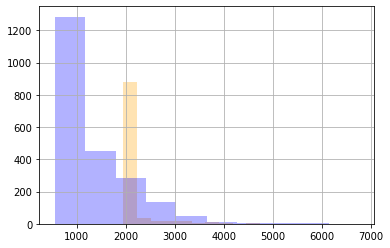

In [27]:
df_common.loc[df_common['tariff'] == 'ultra', 'fee'].hist(color = 'orange', alpha = 0.3) # Ультра оранжевый
df_common.loc[df_common['tariff'] == 'smart', 'fee'].hist(color = 'blue', alpha = 0.3) #Смарт синий

Распределение трат нормальным быть не может, потому что меньше стоимости собственного пакета заплатить нельзя- график сдвинут влево по оси абсцисс. Минимальное значение- абонентская плата.

__Минуты разговора:__

In [28]:
#Smart
df_common.loc[df_common['tariff'] == 'smart', 'calls_duration'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: calls_duration, dtype: float64

In [29]:
#Ultra
df_common.loc[df_common['tariff'] == 'ultra', 'calls_duration'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: calls_duration, dtype: float64

Интересно, но по телефону люди говорят в среднем одинаково немного: общение по телефонной связи заменил интернет, в том числе звонками.

Среднее количество минут разговоров у пользователей разных тарифов очень близкое, как и медиана. Вот только у тарифа смарт стандартное отклонение почти в два раза меньше, чем у ультра, что говорит о том, что среди пользователей тарифа ультра есть больше тех, кто говорит реально значительно больше среднего.

Другими словами, у пользователей тарифа "Ультра" гораздо больше пользователей, которые говорят много больше или много меньше среднего.

То есть гистограмма у "Ультра" должна выглядеть шире.

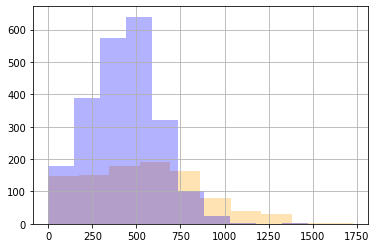

In [30]:
df_common.loc[df_common['tariff'] == 'ultra', 'calls_duration'].hist(color = 'orange', alpha = 0.3) #Ультра оранжевый
df_common.loc[df_common['tariff'] == 'smart', 'calls_duration'].hist(color = 'blue', alpha = 0.3) #Смарт синий

Обе гистограммы скошены влево: говорящих мало всё-таки больше, эпоха интернета берёт своё. 

_Посмотрим на интернет_

__Использование интернета__

In [31]:
#Тариф "Ультра"
df_common.loc[df_common['tariff'] == 'ultra', 'mb_used'].describe()

count      985.000000
mean     19486.901523
std      10096.317202
min          0.000000
25%      11785.000000
50%      19324.000000
75%      26863.000000
max      49789.000000
Name: mb_used, dtype: float64

In [32]:
#Тариф "Смарт"
df_common.loc[df_common['tariff'] == 'smart', 'mb_used'].describe()

count     2229.000000
mean     16229.188425
std       5877.576978
min          0.000000
25%      12658.000000
50%      16531.000000
75%      20068.000000
max      38610.000000
Name: mb_used, dtype: float64

Средний пользователь "Ультра" тратит почти столько же, сколько средний пользователь "Смарт": 19 против 16 гигабайт.

При этом если просмотреть на квартили, поведение пользователей "Ультра" становится явно отличающимся: гистограмма явно будет толще, что видно и по стандартному отклонению.

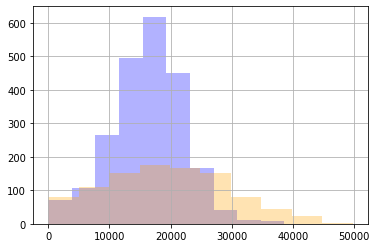

In [33]:
df_common.loc[df_common['tariff'] == 'smart', 'mb_used'].hist(color = 'blue', alpha = 0.3) # Смарт синий
df_common.loc[df_common['tariff'] == 'ultra', 'mb_used'].hist(color = 'orange', alpha =0.3) #Ультра оранжевый

Распределение у пользователей "Ультра" скошено вправо, а у "Смарта"- влево. Кроме того, распределение пользователей смарта ближе к нормальному- отчасти, потому что у нас больше данных про пользователей смарт:

In [34]:
df_common.groupby('tariff').count()

,user_id,month,messages_amount,calls_duration,calls_amount,mb_used,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,message_overuse,internet_overuse,minutes_overuse,fee
tariff,,,,,,,,,,,,,,,,,,
smart,2229,2229,2229,2229,2223,2229,2229,2229,2229,2229,2229,2229,2229,2229,2229,2229,2229,2229
ultra,985,985,985,985,951,985,985,985,985,985,985,985,985,985,985,985,985,985


В 2.5 раза больше информации про тариф "смарт" в любом случае влияет на более нормальный вид графиков.

In [35]:
1915 / 752

2.546542553191489

__СМС__

In [36]:
#Тариф Смарт

df_common.loc[df_common['tariff'] == 'smart', 'messages_amount'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_amount, dtype: float64

In [37]:
#Тариф Ультра

df_common.loc[df_common['tariff'] == 'ultra', 'messages_amount'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages_amount, dtype: float64

Опять-таки, средний и медианный пользователь тарифа "Смарт" тратит меньше, чем пользователь "Ультра", что логично, ведь на то он у "Ультра".

При этом медиана практически совпадает со средним.

Количество смс- единственное дискретное из трёх значений (интернет, звонки, смс), что слегка повлияет на вид гистограмм. Более того, очень многие пользователи совершенно не пользуются СМС-сервисом, в отличие от звонков и интернета. Будет явным скошенность данных влево, распределение будет мало похоже на нормальное.

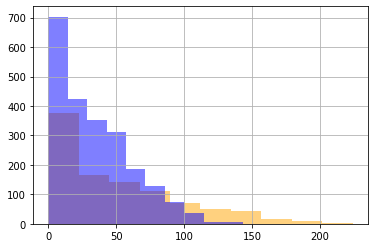

In [38]:
df_common.loc[df_common['tariff'] == 'ultra', 'messages_amount'].hist(alpha=0.5, color = 'orange') # ultra оранжевый
df_common.loc[df_common['tariff'] == 'smart', 'messages_amount'].hist(alpha=0.5, color = 'blue') # smart синий

Что и требовалось доказать, такое распределение сложно назвать нормальным. Мало кто шлёт смс-ки в наши дни. Весь смс-траффик забрали мессенджеры и соцсети.

## Вывод

Поведение клиентов смарт и ультра разительно не отличается: "Ультра" просто потребляют больше, оправдывая таким образом покупку своего пакета. 
- Средний пользователь _SMART_ пишет 28 смс-ок, тратит 16 ГБ интернета (что на 1 ГБ больше, чем включено в тариф) и звонит 429 минут. Получается, средний "смарт" перерасходует интернет- важная информация для "Мегалайна".
- Средний пользователь _ULTRA_ пишет 49 смс-ок, тратит 19 ГБ интернета (что на 11 ГБ меньше, чем включено в тариф: лишних денег на таких пользователях не заработаешь), и звонит 540 минут в месяц. Благо, абонентская плата у них и так высокая. __Возможно, средний пользователь Ultra переплачивает:__ за превышенные над "смартом" расходы нужно доплатить лишь 720 рублей, то есть суммарная плата составит лишь ~1200 рублей (при смарте с доплатами за перерасход) против 1900 "ультравских".

Но есть и различия:

- Так, расходы на оплату тарифа у пользователей "Ультра" ближе к среднему значению: стандартное отклонение почти в три раза меньше, чем у "Смарт". Это значит, что "Ультра" реже переплачивают за пакет, то есть реже тратят больше, чем включено в их тариф.
- Пользователи "Ультра" говорят больше, что очевидно. Но при этом и количество пользователей пакета, которые говорят много больше или много меньше среднего, значительно выше: стандартное отклонение у "Ультра" почти в два раза больше, чем у "Смарт". Гистограммы обоих тарифов скошены влево: бОльшее количество пользователей в выборке говорит меньше среднего.
- Интернетом пользователи разных тарифов пользуются по-разному, что видно по гистограммам: у "Ультра" скос вправо, у "Смарта"- влево. Да и стандартное отклонение (а, следовательно, и дисперсия) у смарта меньше- почти в два раза. Значит, и гистограмма менее широкая.
- СМС сообщения нормальному распределению не подчиняются, потому что в наше время весь траффик написанных сообщений на себя забирают мессенджеры, которые ходят в "интернет". Более того, количество СМС- единственный дискретный параметр в исследовании.

_Более подробные подвыводы есть под каждым пунктом отдельно_

---

## Шаг 4. Гипотезы

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Нулевая гипотеза Ho- средняя выручка пользователей не различается. Проверим. Тогда средние совокупностей должны быть равны между собой.

In [39]:
smart = df_common.loc[df_common['tariff'] == 'smart', 'fee']
ultra = df_common.loc[df_common['tariff'] == 'ultra', 'fee']
results = st.ttest_ind(
smart,
ultra, equal_var = False) #стандартные отклонения: 313 у Ультра и 800 у Смарта, дисперсии не равны.
print('p-значение: ', results.pvalue)

p-значение:  3.08425990878519e-282


In [40]:
#Введём 
alpha = 0.01
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('Средняя выручка ultra', df_common.loc[df_common['tariff'] == 'ultra', 'fee'].mean())
print('Средняя выручка smart', df_common.loc[df_common['tariff'] == 'smart', 'fee'].mean())

Отвергаем нулевую гипотезу
Средняя выручка ultra 2060.5299710501267
Средняя выручка smart 1250.3252404385375


Выручка различается. Выручка тарифа "Ультра" выше чем у тарифа "Смарт". Почти в два раза.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза Ho- средняя выручка москвичей равна средней выручке остальных. Проверим. Тогда средние совокупностей должны быть равны между собой.

In [41]:
df_common.loc[df_common['city'] == 'Москва', 'fee'].describe()

count     611.000000
mean     1517.037809
std       740.816989
min       550.000000
25%       766.000000
50%      1730.273438
75%      1950.000000
max      5222.429688
Name: fee, dtype: float64

In [42]:
df_common.loc[df_common['city'] != 'Москва', 'fee'].describe()

count    2603.000000
mean     1494.309213
std       797.207489
min       550.000000
25%       704.500000
50%      1544.335938
75%      1950.000000
max      6765.015625
Name: fee, dtype: float64

In [43]:
moskvich = df_common.loc[df_common['city'] == 'Москва', 'fee']
ne_moskvich = df_common.loc[df_common['city'] != 'Москва', 'fee']

results = st.ttest_ind(
moskvich,
ne_moskvich, equal_var = True) #стандартные отклонения: 789 и 755, считаем дисперсии равными.
print('p-значение: ', results.pvalue)

p-значение:  0.5205321893722812


In [44]:
#Введём 
alpha = 0.01
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
print('Средняя выручка в Москве', df_common.loc[df_common['city'] == 'Москва', 'fee'].mean())
print('Средняя выручка не в Москве', df_common.loc[df_common['city'] != 'Москва', 'fee'].mean())

Не получилось отвергнуть нулевую гипотезу
Средняя выручка в Москве 1517.0378094312603
Средняя выручка не в Москве 1494.3092127773243


## Вывод

__Гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается":__
- Нулевая гипотеза "Средняя выручка не отличается" может быть отвергнута

_При этом дисперсии выборок не равны между собой, что было учтено в расчётах_

__Гипотеза "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов":__
- Нулевая гипотеза "Средняя выручка не отличается" не может быть отвергнута. Действительно, средние выручки очень близки.

---

# Общий вывод

Я провёл предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно было проанализировать поведение клиентов и сделать вывод — какой тариф лучше. __Кратко:__

__Мы не смогли отвергнуть гипотезу о том, что выручка тарифов не различается (Шаг 4)__, но нужно понимать, что явно сказать, что Ультра лучше, нельзя: это всё-таки очень разные тарифы для разных людей, как показал анализ данных (Шаг 3).

__В ходе работы:__

-  ### Обработали пять начальных датасетов, избавились от ошибок в них ( в основном, с типами данных)
- ### Пересчитали минуты звонков, округлив каждое из значений длительности в бОльшую сторону: именно так считают деньги операторы.
- ### Объединили таблицы в одну большую и посчитали помесячную выручку с каждого клиента. Клиенты, которые перестали пользоваться услугами тарифов, выборке не помешали: мы посчитали те периоды, в которых они присутствовали.
- ### Исследовали поведение клиентов:

Поведение клиентов смарт и ультра разительно не отличается: "Ультра" просто потребляют больше, оправдывая таким образом покупку своего пакета. Но есть и различия:

1) Так, расходы на оплату тарифа у пользователей "Ультра" ближе к среднему значению: стандартное отклонение почти в три раза меньше, чем у "Смарт". Это значит, что "Ультра" реже переплачивают за пакет, то есть реже тратят больше, чем включено в их тариф.

2) Пользователи "Ультра" говорят больше, что очевидно. Но при этом и количество пользователей пакета, которые говорят много больше или много меньше среднего, значительно выше: стандартное отклонение у "Ультра" почти в два раза больше, чем у "Смарт". Гистограммы обоих тарифов скошены влево: бОльшее количество пользователей в выборке говорит меньше среднего.

3) Интернетом пользователи разных тарифов пользуются по-разному, что видно по гистограммам: у "Ультра" скос вправо, у "Смарта"- влево. Да и стандартное отклонение (а, следовательно, и дисперсия) у смарта меньше- почти в два раза. Значит, и гистограмма менее широкая.

4) СМС сообщения нормальному распределению не подчиняются, потому что в наше время весь траффик написанных сообщений на себя забирают мессенджеры, которые ходят в "интернет". Более того, количество СМС- единственный дискретный параметр в исследовании.

- ### Выдвинули и проверили две гипотезы:

1) Гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается":

Нулевая гипотеза "Средняя выручка не отличается" может быть отвергнута
При этом дисперсии выборок не равны между собой, что было учтено в расчётах

2) Гипотеза "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов":

Нулевая гипотеза "Средняя выручка не отличается" не может быть отвергнута. Действительно, средние выручки очень близки.
